In [1]:
import re

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

import dask_geopandas
from collections import OrderedDict

import s3fs
import base64
import json
import os
import requests
import pandas as pd
import numpy as np
import xarray as xr
from tqdm import tqdm
import geopandas as gpd
import netCDF4 as nc
from dotenv import load_dotenv

In [2]:
maryland = gpd.read_file(r'Data\US_SHAPEFILES\State_Boundary\us-state-boundaries.shp')
maryland = maryland[maryland.name == 'Maryland'][["geometry"]].reset_index(drop=True)

<AxesSubplot: >

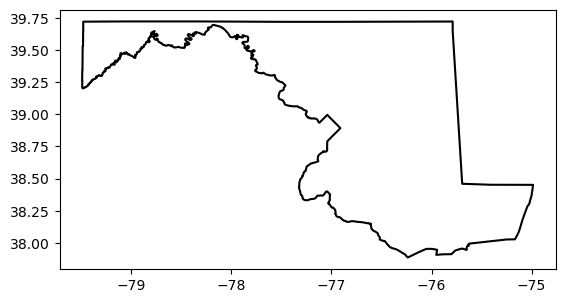

In [3]:
ax = plt.subplot()
maryland.geometry.boundary.plot(ax=ax, color="black")

In [4]:
road = gpd.read_file(r"C:\Users\neupa\Downloads\Maryland_Annual_Average_Daily_Traffic_-_Annual_Average_Daily_Traffic_(SHA_Statewide_AADT_Lines)\Maryland_Annual_Average_Daily_Traffic_-_Annual_Average_Daily_Traffic_(SHA_Statewide_AADT_Lines).shp")
road = road[road["ID_PREFIX"].isin(["MD", "IS"])]

In [6]:
# important_routes = {95, 695, 70, 270, 495, 83, 50, 32, 5, 29}

In [7]:
# filtered_df = road[(road["ID_PREFIX"].isin(["IS", "MD"])) & (road["ID_RTE_NO"].astype(int).isin(important_routes))]
filtered_df = road.copy()

In [8]:
filtered_df = filtered_df[["ID_PREFIX", "ID_RTE_NO", "COUNTY_DES", "ROADNAME", "ROAD_SECTI", "RURAL_URBA", "AADT_2018_", "geometry"]]
filtered_df = filtered_df.reset_index(drop=True)
filtered_df["ROAD_ID"] = range(1, len(filtered_df)+1)

In [9]:
import shapely

def create_fishnet(polygon, width_degree, height_degree):
    country_regions = polygon.geometry.explode(index_parts=True).tolist()
    max_region = max(country_regions, key=lambda a: a.area)
    xmin, ymin, xmax, ymax = polygon.total_bounds
    cell_width  = width_degree
    cell_height = height_degree
    grid_cells = []
    
    ''' CREATING PIXELS/GRIDS AROUND THE POLYGON '''
    for x0 in tqdm(np.arange(xmin, xmax+cell_width, cell_width )):
        for y0 in np.arange(ymin, ymax+cell_height, cell_height):
            x1 = x0-cell_width
            y1 = y0+cell_height
            new_cell = shapely.geometry.box(x0, y0, x1, y1)
            grid_cells.append(new_cell)
            
    fishnet_x = gpd.GeoDataFrame({'geometry':grid_cells}).set_geometry('geometry').set_crs('EPSG:4326')
    fishnet_x = fishnet_x[['geometry']]
    
    ''' ONLY SELECTING THE CREATED PIXELS THAT INERSECT WITH THE ORIGINAL POLYGON '''
    fishnet_dask = dask_geopandas.from_geopandas(fishnet_x, npartitions=12)
    fishnet_x = dask_geopandas.sjoin(fishnet_dask, polygon, predicate = 'intersects').compute()
    fishnet_x = fishnet_x[['geometry']].reset_index(drop = True)
    
    
    ''' CLIPPING THE PIXELS THAT OVERLAP THE POLYGON TO THE AREA INSIDE THE POLYGON '''
    fishnet_dask = dask_geopandas.from_geopandas(fishnet_x, npartitions=12)
    fishnet_x = dask_geopandas.clip(fishnet_dask, polygon, keep_geom_type = True).compute()
    fishnet_x = fishnet_x[['geometry']].reset_index(drop = True)
    
    return fishnet_x

fishnet = create_fishnet(maryland, 0.1, 0.1)

100%|██████████| 47/47 [00:00<00:00, 1873.70it/s]


In [10]:
filtered_df.to_crs('EPSG:4326', inplace=True)

<AxesSubplot: >

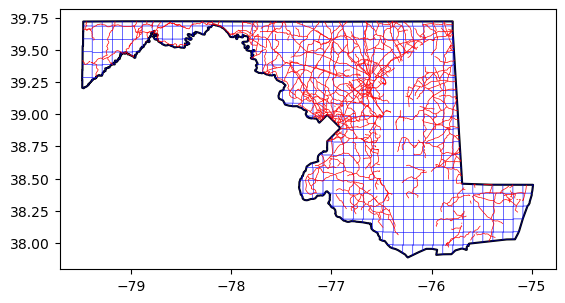

In [11]:
ax = plt.subplot()
maryland.geometry.boundary.plot(ax=ax, color="black")
fishnet.geometry.boundary.plot(ax=ax, color="blue", alpha=0.5, linewidth=0.5)
filtered_df.plot(ax=ax, color="red", alpha=1, linewidth=0.5)

In [12]:
fishnet["ID"] = range(1, len(fishnet)+1)

In [13]:
file_path = r"C:\Users\neupa\OneDrive\Desktop\Spring 2025\DATA 603 - BIGDATA\DATA_603_Project\Data\NO2\Single_Files"
files = os.listdir(file_path)
files = sorted([file for file in files if "2018" in file])
files

['omi_no2_data_2018_01.parquet',
 'omi_no2_data_2018_02.parquet',
 'omi_no2_data_2018_03.parquet',
 'omi_no2_data_2018_04.parquet',
 'omi_no2_data_2018_05.parquet',
 'omi_no2_data_2018_06.parquet',
 'omi_no2_data_2018_07.parquet',
 'omi_no2_data_2018_08.parquet',
 'omi_no2_data_2018_09.parquet',
 'omi_no2_data_2018_10.parquet',
 'omi_no2_data_2018_11.parquet',
 'omi_no2_data_2018_12.parquet']

In [14]:
from shapely import Polygon

def get_polygon(row):
    return Polygon([(row['LON1'], row['LAT1']), (row['LON2'], row['LAT2']),(row['LON3'], row['LAT3']), (row['LON4'], row['LAT4'])])

In [15]:
no2_df = pd.DataFrame()
for file in tqdm(files):
    df = pd.read_parquet(os.path.join(file_path, file))
    df = df[(df.cloudFraction <= 0.6) & (df.ColumnAmountNO2 >= 0)]

    df = df[(df["longitude"] >= maryland.total_bounds[0]) & 
        (df["longitude"] <= maryland.total_bounds[2]) & 
        (df["latitude"] >= maryland.total_bounds[1]) & 
        (df["latitude"] <= maryland.total_bounds[3])]
    
    no2_df = pd.concat([no2_df, df], ignore_index=True)

100%|██████████| 12/12 [00:01<00:00,  8.06it/s]


In [16]:
from tqdm.notebook import tqdm
tqdm.pandas()

In [17]:
no2_df['rectangle'] = no2_df.progress_apply(get_polygon, axis = 1)

  0%|          | 0/19679 [00:00<?, ?it/s]

In [18]:
no2_df["geometry_point"] = gpd.points_from_xy(no2_df["longitude"], no2_df["latitude"])
no2_df = gpd.GeoDataFrame(no2_df, geometry="geometry_point", crs="EPSG:4326")

<AxesSubplot: >

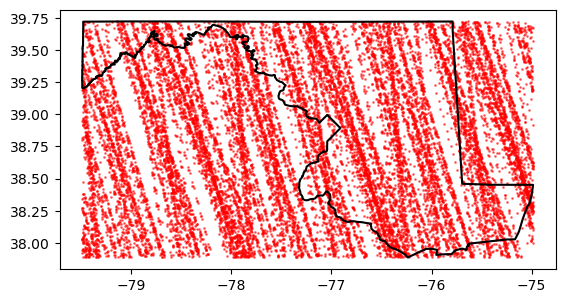

In [19]:
ax= plt.subplot()
maryland.geometry.boundary.plot(ax=ax, color="black")
no2_df.geometry_point.plot(ax=ax, color="red", alpha=0.5, markersize=1)

In [20]:
no2_df = gpd.GeoDataFrame(no2_df, geometry="rectangle", crs="EPSG:4326")

<AxesSubplot: >

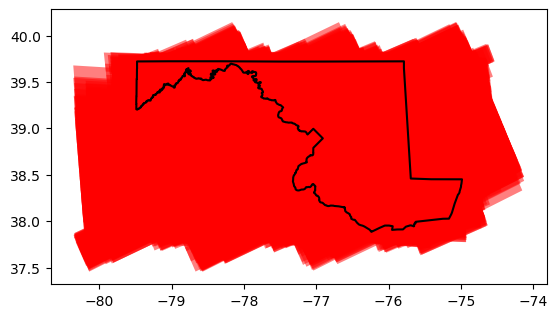

In [21]:
ax= plt.subplot()
maryland.geometry.boundary.plot(ax=ax, color="black")
no2_df.rectangle.plot(ax=ax, color="red", alpha=0.5, markersize=1)

# Only get grids that intersect with roadways

In [22]:
road_segment = filtered_df[["ROAD_ID", "geometry"]].copy()

In [23]:
intersection_grids = fishnet.sjoin(road_segment, predicate = 'intersects')

<AxesSubplot: >

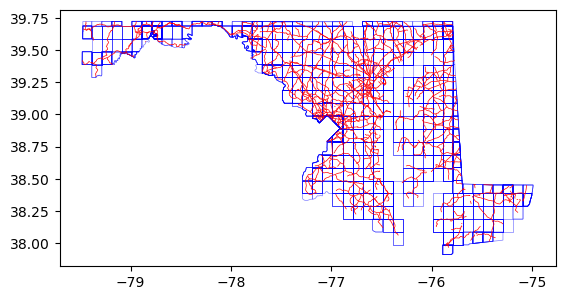

In [24]:
ax= plt.subplot()
intersection_grids.geometry.boundary.plot(ax=ax, color="blue", alpha=0.5, linewidth=0.5)
road_segment.plot(ax=ax, color="red", alpha=1, linewidth=0.5)

In [25]:
intersection_grids.reset_index(drop=True, inplace=True)
try:
    intersection_grids.drop(columns=["index_right"], inplace=True)
except:
    pass

In [26]:
intersection_grids

,geometry,ID,ROAD_ID
0,"POLYGON ((-79.38765 39.3866, -79.28765 39.3866...",4,338
1,"POLYGON ((-79.38765 39.3866, -79.28765 39.3866...",4,403
2,"POLYGON ((-79.38765 39.4866, -79.38765 39.3866...",6,1889
3,"POLYGON ((-79.38765 39.4866, -79.38765 39.3866...",6,893
4,"POLYGON ((-79.38765 39.4866, -79.38765 39.3866...",6,499
...,...,...,...
3531,"POLYGON ((-75.18765 38.45195, -75.08765 38.451...",409,807
3532,"POLYGON ((-75.18765 38.45195, -75.08765 38.451...",409,916
3533,"POLYGON ((-75.08765 38.45179, -74.98765 38.451...",410,1351
3534,"POLYGON ((-75.08765 38.45179, -74.98765 38.451...",410,1580


In [27]:
%%time

result = fishnet.sjoin(no2_df, predicate = 'intersects')

CPU times: total: 219 ms
Wall time: 352 ms


In [28]:
result.shape

(216248, 17)

In [29]:
from collections import OrderedDict
def get_ordered_dict(dx, IDs):
    for id_ in IDs:
        if id_ not in dx.keys():
            dx[id_] = np.nan
    
    dict1 = dict(OrderedDict(sorted(dx.items())))
    return np.array(list(dict1.values()))

fishnet["NO2"]  = get_ordered_dict(dict(result.groupby('ID', dropna = False)['ColumnAmountNO2'].mean()), fishnet['ID'])

In [30]:
fishnet

,geometry,ID,NO2
0,"POLYGON ((-79.38765 39.2866, -79.38765 39.2633...",1,4.829818e+15
1,"POLYGON ((-79.38765 39.2866, -79.34396 39.2866...",2,4.822545e+15
2,"POLYGON ((-79.38765 39.3866, -79.38765 39.2866...",3,4.893444e+15
3,"POLYGON ((-79.38765 39.3866, -79.28765 39.3866...",4,5.032865e+15
4,"MULTIPOLYGON (((-79.28765 39.3866, -79.19857 3...",5,5.028179e+15
...,...,...,...
406,"POLYGON ((-75.38765 38.45226, -75.28765 38.452...",407,5.478847e+15
407,"POLYGON ((-75.28765 38.4521, -75.18765 38.4519...",408,5.523093e+15
408,"POLYGON ((-75.18765 38.45195, -75.08765 38.451...",409,5.490153e+15
409,"POLYGON ((-75.08765 38.45179, -74.98765 38.451...",410,5.312188e+15


<AxesSubplot: >

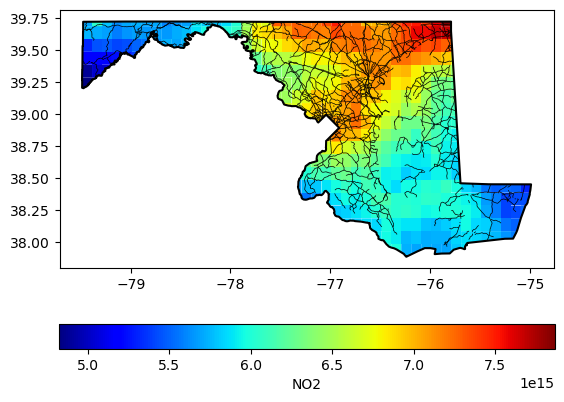

In [31]:
ax= plt.subplot()
maryland.geometry.boundary.plot(ax=ax, color="black")
fishnet.plot(column="NO2", ax=ax, cmap="jet", alpha=1, legend=True, legend_kwds={'label': "NO2", 'orientation': "horizontal"})
road_segment.plot(ax=ax, color="black", alpha=1, linewidth=0.5)

In [32]:
fishnet

,geometry,ID,NO2
0,"POLYGON ((-79.38765 39.2866, -79.38765 39.2633...",1,4.829818e+15
1,"POLYGON ((-79.38765 39.2866, -79.34396 39.2866...",2,4.822545e+15
2,"POLYGON ((-79.38765 39.3866, -79.38765 39.2866...",3,4.893444e+15
3,"POLYGON ((-79.38765 39.3866, -79.28765 39.3866...",4,5.032865e+15
4,"MULTIPOLYGON (((-79.28765 39.3866, -79.19857 3...",5,5.028179e+15
...,...,...,...
406,"POLYGON ((-75.38765 38.45226, -75.28765 38.452...",407,5.478847e+15
407,"POLYGON ((-75.28765 38.4521, -75.18765 38.4519...",408,5.523093e+15
408,"POLYGON ((-75.18765 38.45195, -75.08765 38.451...",409,5.490153e+15
409,"POLYGON ((-75.08765 38.45179, -74.98765 38.451...",410,5.312188e+15


In [33]:
intersection_grids = intersection_grids.merge(fishnet[["ID", "NO2"]], on="ID", how="left")

<AxesSubplot: >

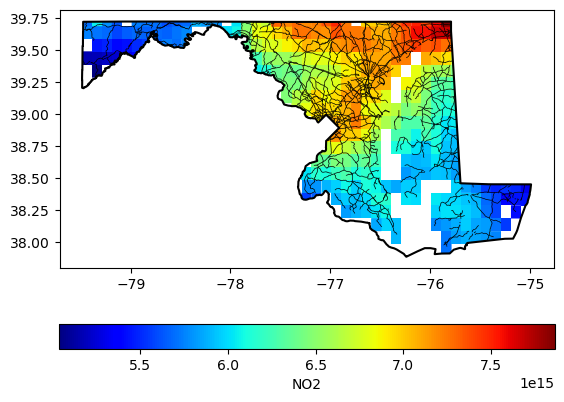

In [34]:
ax= plt.subplot()
maryland.geometry.boundary.plot(ax=ax, color="black")
intersection_grids.plot(column="NO2", ax=ax, cmap="jet", alpha=1, legend=True, legend_kwds={'label': "NO2", 'orientation': "horizontal"})
road_segment.plot(ax=ax, color="black", alpha=1, linewidth=0.5)

In [35]:
average_no2_for_each_roadway = intersection_grids.groupby("ROAD_ID")["NO2"].mean().reset_index()

In [36]:
filtered_df = filtered_df.merge(average_no2_for_each_roadway, on="ROAD_ID", how="left")

In [37]:
a = filtered_df[["AADT_2018_", "NO2"]].copy()

In [43]:
a = a[a["AADT_2018_"] != "N/A"]

In [ ]:
a["AADT_2018_"] = a["AADT_2018_"].apply(lambda x : x.replace(",", "")).astype(float)

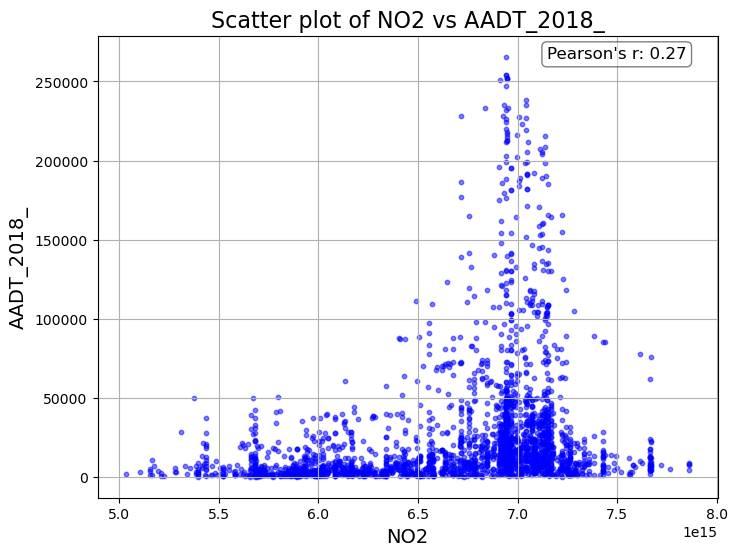

In [47]:
y = "AADT_2018_"
x = "NO2"

from scipy.stats import pearsonr

temp = a[[x, y]].dropna()
temp = temp[temp[x] <=0.8e+16]

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(temp[x], temp[y], alpha=0.5, s=10, c='blue')
ax.set_xlabel(x, fontsize=14)
ax.set_ylabel(y, fontsize=14)
ax.set_title(f"Scatter plot of {x} vs {y}", fontsize=16)

# Add Pearson's correlation coefficient to the plot
ax.text(0.95, 0.95, f"Pearson's r: {round(temp[[x, y]].corr().values[0][1], 3):.2f}", 
    transform=ax.transAxes, fontsize=12, ha='right', 
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.5))

ax.grid(True)
plt.show()